# Foreword

This notebook will be used to train and test a Semantic Segmentation model to use with autonomous vehicle camera.

## Goal

In this notebook, I'll fetch create a DataGenerator class to fetch a small sample of the train/test dataset on each model epoch. Models will be compared, best model will then be tuned and trained on the whole dataset with augmented images if needed.

## Process

- Configure data folders
- Create DataGenerator class with Keras Sequential
- Quickly train and compare untrained models with non augmented datas
- Quickly train and compare untrained models with augmented datas
- Quickly train and compare pre-trained models with augmented datas / different backbones
- Hypertune selected model
- Train selected model on the whole set
- Register final models
- Deploy the model on Azure ACI
- Develop a Flask API to get model predictions

## Requirements

To run this notebook you'll need:

albumentations==1.0.3

azure-common==1.1.27

azure-core==1.18.0

azureml==0.2.7

azureml-contrib-services==1.34.0

azureml-sdk==1.34.0

ipykernel==4.10.1

joblib==1.0.1

keras==2.6.0

matplotlib==3.2.2

numpy==1.19.5

opencv-python-headless==4.5.3.56

pandas==1.1.5

segmentation-models==1.0.3

tensorflow==2.6.0





# Importing Libraries

In [1]:
!pip uninstall albumentations -y
! pip install albumentations==1.0.3
!pip install segmentation_models

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 98 kB 2.5 MB/s 
     |████████████████████████████████| 37.1 MB 84 kB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 


In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
import time, random
import joblib
from datetime import datetime
import glob 

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import albumentations as A
import segmentation_models as sm

from tqdm.notebook import tqdm

Segmentation Models: using `keras` framework.


In [3]:
%%capture
tqdm().pandas()

In [4]:
sm.set_framework('tf.keras')

sm.framework()
A.__version__

'1.0.3'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

<div style='background:#96d6ee;' class='alert alert-block alert-info'><span style='color: #3c6f9c' >Functions coded to evaluate, compare, display curves and results etc.</span></div>

In [36]:
cats_ = [
        
[0, 1, 2, 3, 4, 5, 6],
[7, 8, 9, 10],
[11, 12, 13, 14, 15, 16],
[17, 18, 19, 20],
[21, 22],
[23],
[24, 25],
[26, 27, 28, 29, 30, 31, 32, 33, -1]
]


def show_curves(histories):
    plt.figure(figsize=(14,20))
    a = 3  # number of rows
    b = 4  # number of columns
    c = 1  # initialize plot counter
    # plt.title("curves")
    # fig, axs = plt.subplots(3, 4, figsize=())
    for index, history in enumerate(histories):
        # history = list(history)
        plt.subplot(a, b, c)
        plt.plot(history['history'].history['loss'], label = 'train')
        plt.plot(history['history'].history['val_loss'], label = 'val')
        plt.title("{} train vs val loss".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1

        plt.subplot(a, b, c)
        plt.plot(history['history'].history['accuracy'], label = 'train')
        plt.plot(history['history'].history['val_accuracy'], label = 'val')
        plt.title("{} train vs val accuracy".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend( loc='best')
        c = c +1

        plt.subplot(a, b, c)
        plt.plot(history['history'].history['f1-score'], label = 'train')
        plt.plot(history['history'].history['val_f1-score'], label = 'val')
        plt.title("{} train vs val dice".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1

        plt.subplot(a, b, c)
        plt.plot(history['history'].history['iou_score'], label = 'train')
        plt.plot(history['history'].history['val_iou_score'], label = 'val')
        plt.title("{} train vs val IoU".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1
    plt.show()

def add_to_comparison_table(df, results):
    label = results['name']
    keys_to_remove = ["model", "name"]
    for key in keys_to_remove:
        del results[key]
        
    res = pd.DataFrame(results.values(), index= results.keys(), columns=[label])
    return pd.concat([df, res], axis=1)

def evaluate_model(models, comparison_df, train_gen, test_gen, train_steps, val_steps, batch_size, epochs): 
    histories = []
    for name, model in models.items():
        start = time.time()
    
        # fit network
        # batch_size = 16
        # epochs = 15
        history = model.fit(
            train_gen,
            validation_data=test_gen,
            batch_size=batch_size,
            epochs=epochs,
            workers=32,
            use_multiprocessing = True,
            steps_per_epoch=train_steps, 
            validation_steps=val_steps,
            callbacks= create_callbacks(name)
        )
        end = time.time()
        training_time = end - start
        histories.append({'name': name, 'history': history})
        results_dict = {'model': model,
                        'name': name,
                        'train time': training_time,
                        'Accuracy': np.max(history.history['val_accuracy']),
                        'IoU': np.max(history.history['val_iou_score']),
                        'Dice': np.max(history.history['val_f1-score']),
                        # 'score' : np.max(history.history['AUC'])
                        }
        comparison_df = add_to_comparison_table(comparison_df, results_dict)
    return comparison_df, histories

def get_GT_array(i):

    lbl = cv2.imread(val_label[i], cv2.IMREAD_GRAYSCALE)       
    # print("LBL ", label_path, lbl)
    lbl = cv2.resize(lbl, (img_height, img_width))
    lbl
    new_lbl = []
    for r in lbl.flatten():
        for i, cat in enumerate(cats_):
            if r in cat:
                new_lbl.append(i)
                continue  
    print("GT -> ")
    stack = np.bincount(np.array(new_lbl))
    ii = np.nonzero(stack)[0]
    display(np.vstack((ii,stack[ii])).T)
    
def show_img_grid(img, gt, pred, title=''):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(131)
    ax.set_title('Image')
    ax.imshow(img)

    ax1 = fig.add_subplot(132)
    ax1.set_title('Ground truth {}'.format(title))
    ax1.imshow(gt.astype('uint8'))

    ax1 = fig.add_subplot(133)
    ax1.set_title("Prediction {}".format(title))
    ax1.imshow(pred.astype('uint8'))

def get_eval(model, i, on_train=False):

    color_map = {
        '0': [0, 0, 0],
        '1': [128, 64, 128],
        '2': [70, 70, 70],
        '3': [140, 151, 148],
        '4': [35, 142, 107],
        '5': [180, 130, 70],
        '6': [0, 0, 255],
        '7': [142, 0, 0]
    }
    img = cv2.imread(val_img[i], cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_height, img_width))

    dims = img.shape

    exp_img = np.expand_dims(img, axis=0)
    BACKBONE2 = 'inceptionv3'
    preprocess_input2 = sm.get_preprocessing(BACKBONE2)
    exp_img = preprocess_input2(exp_img)
    z = model.predict(exp_img)

    z = np.squeeze(z)
    z = z.reshape(img_height, img_width, 8)
    z = cv2.resize(z, (dims[1], dims[0]))
    y = np.argmax(z, axis=2)

    img_color = img.copy()   
    for i in range(dims[0]):
        for j in range(dims[1]):
            img_color[i, j] = color_map[str(y[i, j])]
    
    return img, img_color

def show_curves_TF(histories):
    plt.figure(figsize=(14,20))
    a = 3  # number of rows
    b = 4  # number of columns
    c = 1  # initialize plot counter
    # plt.title("curves")
    # fig, axs = plt.subplots(3, 4, figsize=())
    for index, history in enumerate(histories):
        # history = list(history)
        plt.subplot(a, b, c)
        plt.plot(history['history'].history['loss'], label = 'train')
        plt.plot(history['history'].history['val_loss'], label = 'val')
        plt.title("{} train vs val loss".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1

        plt.subplot(a, b, c)
        plt.plot(history['history'].history['f1-score'], label = 'train')
        plt.plot(history['history'].history['val_f1-score'], label = 'val')
        plt.title("{} train vs val dice".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1

        plt.subplot(a, b, c)
        plt.plot(history['history'].history['iou_score'], label = 'train')
        plt.plot(history['history'].history['val_iou_score'], label = 'val')
        plt.title("{} train vs val IoU".format(history['name']))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(loc='best')
        c = c +1
    plt.show()


def get_random_data(nb):
    train_images, train_masks_lbl = [], []

    for i in range(0, nb):
        train_images.append(allAug_img[i])
        train_masks_lbl.append(allAug_lbl)
    return train_images, train_masks_lbl

# Dataset

In [7]:

train_img = glob.glob('/content/drive/MyDrive/P8/all/left/train/*/*.png') 
img_names = [path.split('/train/')[1].split('_leftImg8bit.png')[0] for path in train_img]
train_label = ['/content/drive/MyDrive/P8/all/gt/train/' + name + '_gtFine_labelIds.png' for name in img_names]

# len(img)
index = np.random.permutation(len(train_img))
train_img = np.array(train_img)[index]
train_label = np.array(train_label)[index]

test_img = glob.glob('/content/drive/MyDrive/P8/all/left/test/*/*.png') 
test_img_names = [path.split('/test/')[1].split('_leftImg8bit.png')[0] for path in test_img]
test_label = ['/content/drive/MyDrive/P8/all/gt/test/' + name + '_gtFine_labelIds.png' for name in test_img_names]


val_img = glob.glob('/content/drive/MyDrive/P8/all/left/val/*/*.png') 
val_img_names = [path.split('/val/')[1].split('_leftImg8bit.png')[0] for path in val_img]
val_label = ['/content/drive/MyDrive/P8/all/gt/val/' + name + '_gtFine_labelIds.png' for name in val_img_names]
val_gt = ['/content/drive/MyDrive/P8/all/gt/val/' + name + '_gtFine_color.png' for name in val_img_names]

print(len(train_label), len(val_label))

train_img.sort()
train_label.sort()
print(f'Number of images: {len(train_img)}\nNumber of masks: {len(train_label)}')

# sanity check
for i in range(len(train_img)):
    assert train_img[i][37:-16] == train_label[i][35:-20]

2972 500
Number of images: 2972
Number of masks: 2972


In [8]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

# Data Generator

## Parameters

Global parameters

In [9]:
BATCH_SIZE = 32
img_width, img_height = 256, 256
classes = 8

## Data augmentation sequence

Albumentations will take the image/mask pair and randomly apply one or more effects.

In [10]:
import albumentations as A
transform = A.Compose([
                       A.SomeOf([
                                 A.OneOf([
                                  A.Affine(scale=(-0.5, 0.5)),
                                  A.Affine(rotate=(-30, 30)),        
                                 ]),
                            A.OneOf([
                                    A.HorizontalFlip(),
                                    A.ShiftScaleRotate(),
                                ]),
                                A.OneOf([
                                        A.Blur(),
                                        A.GaussianBlur(),
                                        A.MotionBlur()
                                ]),
                            A.OneOf([
                                    A.ISONoise(),

                                ]), 
                            A.OneOf([
                                     A.RandomRain(0.2, 0.4),
                                     A.RandomFog(0.2, 0.4),
                            ]),
                            A.OneOf([
                                # A.Downscale(),
                                A.RandomBrightnessContrast(),
                                A.Perspective()
                            ])
                       ], 2)
])

## Custom class

In [11]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size, data_aug, nb_aug=1, shuffle = False, backbone=None):
        self.image_path_list, self.label_path_list = x_set, y_set
        self.batch_size = batch_size
        self.data_aug = data_aug
        self.nb_aug = nb_aug
        self.shuffle = shuffle
        self.samples = len(self.image_path_list)
        self.backbone = backbone

    def __len__(self):
        return int(np.ceil(len(self.image_path_list) / float(self.batch_size)))

    def __getitem__(self, idx):
        imgs, lbls, batch_x, batch_y = [], [], [], []
        train_imgs = self.image_path_list[idx*self.batch_size:(idx+1)*self.batch_size]
        train_masks = self.label_path_list[idx*self.batch_size:(idx+1)*self.batch_size]
     
        # Dealing with original images
        train_images = []
        for i, img_path in enumerate(train_imgs):
            #checking if no file is corrupted
            if type(img_path) == type(None) or type(train_masks[i]) == type(None): 
                train_masks.pop(i)
                continue
            img = cv2.imread(img_path, 1)
            img = cv2.resize(img, (img_height, img_width))
            train_images.append(img)

        # Dealing with lables   
        train_labels = []
        for i, mask_path in enumerate(train_masks):
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, (img_height, img_width), interpolation = cv2.INTER_NEAREST)
            train_labels.append(mask)
            # try:
            #     mask = cv2.resize(mask, (img_height, img_width), interpolation = cv2.INTER_NEAREST)
            #     train_labels.append(mask)
            # except cv2.error as e:
            #     print(e)
            #     for k in dir(e):
            #         if k[0:2] != "__":
            #             print("e.%s = %s" % (k, getattr(e, k)))
       
        imgs = train_images.copy()
        lbls = train_labels.copy()

        if self.data_aug:
            # Data augmentation
            for run in range (0, self.nb_aug):
                # Do we want to augment more than once ?
                for i in range(0, len(train_images)):
                    aug = transform(image=train_images[i], mask=train_labels[i])
                    imgs.append(aug['image']/255.)
                    lbls.append(aug['mask'])

        if self.shuffle:
            # Shuffling img/masks pair so we don't have all normal images then all augmented images
            shuffle = list(zip(imgs, lbls))
            random.shuffle(shuffle)
            imgs, lbls = zip(*shuffle)

        # Normalizing original images
        train_images = np.array(imgs)/255.
        
        # One hot encoding-like function 32 classes to 8 main groups
        train_masks_lbl = []
        for msk in lbls:   
            img = np.squeeze(msk)
            mask = np.zeros((msk.shape[0], msk.shape[1], 8))
            for i in range(-1, 34):
                if i in cats['void']:
                    mask[:,:,0] = np.logical_or(mask[:,:,0],(img==i))
                elif i in cats['flat']:
                    mask[:,:,1] = np.logical_or(mask[:,:,1],(img==i))
                elif i in cats['construction']:
                    mask[:,:,2] = np.logical_or(mask[:,:,2],(img==i))
                elif i in cats['object']:
                    mask[:,:,3] = np.logical_or(mask[:,:,3],(img==i))
                elif i in cats['nature']:
                    mask[:,:,4] = np.logical_or(mask[:,:,4],(img==i))
                elif i in cats['sky']:
                    mask[:,:,5] = np.logical_or(mask[:,:,5],(img==i))
                elif i in cats['human']:
                    mask[:,:,6] = np.logical_or(mask[:,:,6],(img==i))
                elif i in cats['vehicle']:
                    mask[:,:,7] = np.logical_or(mask[:,:,7],(img==i))
            if self.backbone == None:
                mask = np.resize(mask,(img_height, img_width, 8))   
            else:
                mask = np.resize(mask,(img_height, img_width))

            train_masks_lbl.append(mask)

            batch_y.append(mask)
        
        if self.backbone == None:
            return train_images, np.array(batch_y)
        train_masks = np.array(train_masks_lbl)

        ######## TRANSFER LEARNING #####
        labelencoder = LabelEncoder()

        ########## TRAIN #########
        # print("TM shae", train_masks.shape)
        n, h, w = train_masks.shape #train_masks.shape[1],train_masks.shape[2], train_masks.shape[3] 
        train_masks_reshaped = train_masks.ravel()#reshape(-1,1)
        # print("TM reshape", train_masks_reshaped.shape)
        train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
        # print("TM reshape encoded", train_masks_reshaped_encoded.shape)
        train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
        # print("TM reshape origi", train_masks_encoded_original_shape.shape)
        np.unique(train_masks_encoded_original_shape)

        train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
        train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
        y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))

        ####Backbones###
        BACKBONE1 = self.backbone
        preprocess_input1 = sm.get_preprocessing(BACKBONE1)
        X_train = preprocess_input1(train_images)
        # print(np.array(X_train).shape)
        # print(np.array(y_train_cat).shape)
        return X_train, y_train_cat
       

## Custom models

## MobileNet

In [12]:
def custom_mobilenet(height, width):
    inputs = Input(shape=(height, width, 3), name="input_image")
    print(inputs)
    encoder = MobileNetV2(input_tensor=inputs, weights=None, include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [64, 128, 256, 512]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(8, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

## Unet

In [13]:
def down_block(x, filters, kernel_size=(3, 3), padding="same"):
    c = Conv2D(filters, kernel_size, kernel_initializer="he_normal", padding=padding, activation="relu")(x)
    c = Dropout(0.2)(c)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, kernel_initializer="he_normal", padding=padding, activation="relu")(c)
    c = Dropout(0.2)(c)
    c = BatchNormalization()(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    p = Dropout(0.2)(p)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same"):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, kernel_initializer="he_normal", padding=padding, activation="relu")(concat)
    c = Dropout(0.2)(c)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, kernel_initializer="he_normal", padding=padding, activation="relu")(c)
    c = BatchNormalization()(c)
    c = Dropout(0.2)(c)
    
    return c

def UNet(h, w, filters):
    f = [filters, filters*2, filters*4, filters*8, filters*16, filters*32]
    inputs = Input((h,w,3))
    
    p0 = inputs



    ######### ENCODAGE #########
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2]) 
    c4, p4 = down_block(p3, f[3])
    c5, p5 = down_block(p4, f[4]) 
    c5 = Dropout(0.5)(c5)

    c6, p6 = down_block(p5, f[5]) 
    c6 = Dropout(0.5)(c6)

    ######### DECODAGE #########
    u1 = up_block(c6, c5, f[4])
    u2 = up_block(u1, c4, f[3])
    u3 = up_block(u2, c3, f[2])
    u4 = up_block(u3, c2, f[1])
    u5 = up_block(u4, c1, f[0])

    output_layer = Conv2D(filters=8, kernel_size=(1, 1))(u5)
    output_layer = Reshape((h*w, 8), input_shape=(h, w, 8))(output_layer)
    outputs = Activation('softmax')(output_layer)
    
    model = Model(inputs, outputs)
    return model

# losses

We define loss functions to use. Total loss is a combination of dice loss + focal loss

In [14]:
dice_loss = sm.losses.DiceLoss(smooth=1) 
focal_loss = sm.losses.CategoricalFocalLoss()
iou_loss = sm.losses.JaccardLoss()
total_loss = dice_loss + (1 * focal_loss)

# Callbacks


In [15]:
class visualize(tf.keras.callbacks.Callback):
    '''
        This callback will predict and image and write the output from time to time
        Used to visualize the model's performance evolution
    '''
    def __init__(self, name):

        self.name = name
    def on_train_begin(self, logs={}):
        self.history={'loss': [],'iou_score': [],'val_loss': [],'val_iou_score': []}

    def on_epoch_end(self, epoch, logs):
        if logs.get('val_iou_score', -1) != -1:
            self.history['val_iou_score'].append(logs.get('val_iouval_loss_score'))
        for i in self.history['val_iou_score']:

            if logs.get('val_iou_score')>i:
                iou = round(logs.get('val_iou_score'), 2)
                img, pred = get_prediction(self.model, 137, display=False)
                cv2.imwrite("/content/outputs/{}_e{}_{}.png".format(self.name, epoch, iou), pred)
                
def create_callbacks(name) :
    filepath= "/content/drive/MyDrive/P8/"+name+ '_' + datetime.now().strftime("%d_%m_%Y")
    callbacks=[
            # If no improvement is seen on val_loss after 10 epochs, stop the training and restore best weights
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                mode='min',
                patience=15, # 5 for small datasets, 15 for big
                restore_best_weights=True,
                verbose=1
            ),
            # Save the model each time the monitored metric impoves
            tf.keras.callbacks.ModelCheckpoint(
                filepath,
                monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False
                ),
            # If the model performance is not improving after 5 epochs, divide the LR by a factor of 0.2 until a certain point
            # patience 3 for small datasets, 5 for big
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.001, patience=5, min_lr=0.0001, verbose=1),
            # visualize(name=name)
            ]
    return callbacks

# Compare Losses with Unet model


Compare losses on reduced dataset

In [ ]:

L_focal = UNet(img_height, img_width, 32)
L_focal.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=focal_loss, 
    metrics=[
              # my_32,
              sm.metrics.IOUScore(threshold=0.5, smooth=0.0001),
              sm.metrics.FScore(threshold=0.5, smooth=0.0001),
             "accuracy"
             ])
L_dice = UNet(img_height, img_width, 32)
L_dice.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=dice_loss, 
    metrics=[
              # my_IoU,
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])

L_IoU = UNet(img_height, img_width, 32)
L_IoU.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=iou_loss,
    metrics=[
              # my_IoU,
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])

L_total = UNet(img_height, img_width, 32)
L_total.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=total_loss, 
    metrics=[
              # my_IoU,
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])

models = {
    "L_total" : L_total,
    "L_focal": L_focal,
    "L_IoU": L_IoU,
    "L_Dice": L_dice,
    }


Quick training with 160 total train images, 64 test images, 15 epochs

In [ ]:
train_gen = DataGenerator(train_img[0:160], train_label[0:160], BATCH_SIZE, data_aug = False, shuffle=True)
test_gen = DataGenerator(test_img[0:64], test_label[0:64], BATCH_SIZE, data_aug = False)
val_gen = DataGenerator(val_img, val_label, BATCH_SIZE, data_aug = False)

TRAIN_STEPS = 160 //BATCH_SIZE
VAL_STEPS = 64 //BATCH_SIZE

comp, histories = evaluate_model(models, pd.DataFrame(), train_gen, val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)


L_total     L_focal       L_IoU      L_Dice
train time  270.065870  335.465557  293.289906  632.727455
Accuracy      0.164848    0.164848    0.148842    0.312376
IoU           0.089890    0.089890    0.080482    0.184700
Dice          0.319706    0.319706    0.288663    0.609437

ValueError: ignored

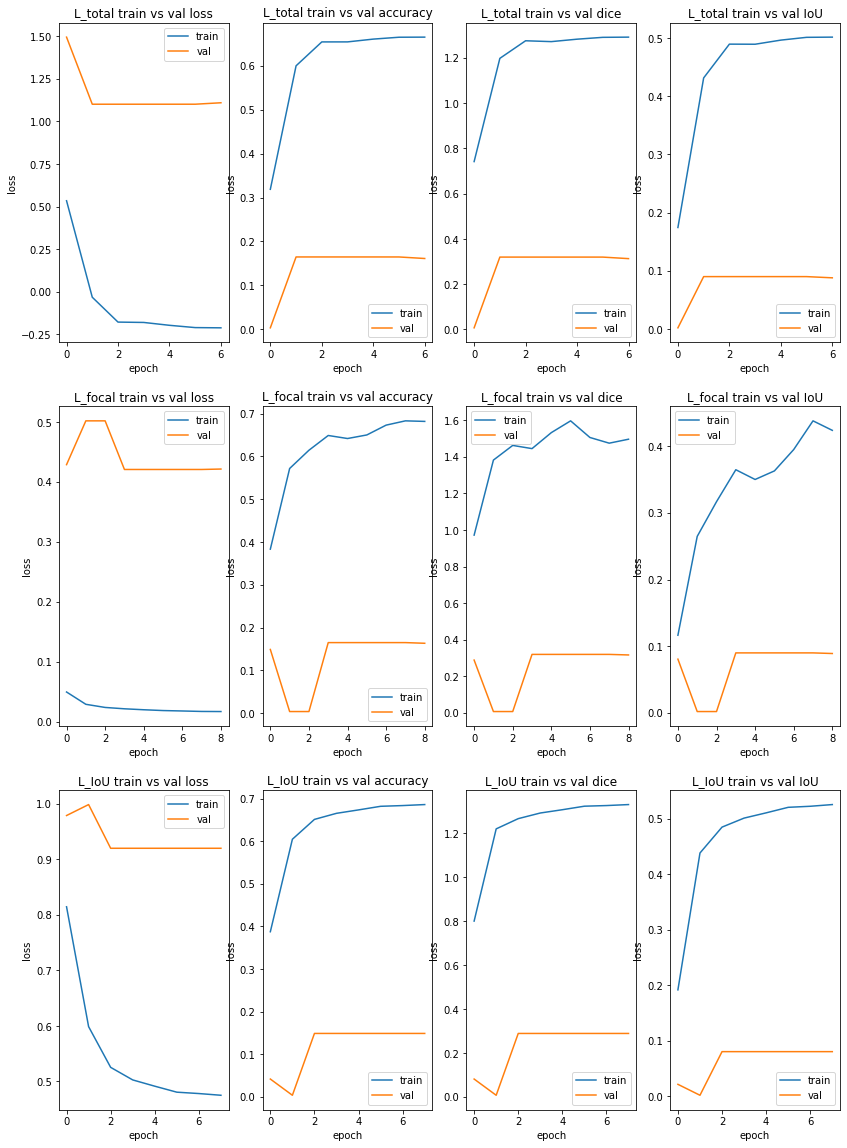

In [ ]:
show_curves(histories)

Model is clearly overfitting, due to the small size of the dataset

# Compare untrained models

## Training with original datas

### Unet

In [ ]:
Unet = UNet(img_height, img_width, 32)
Unet.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=total_loss, 
    metrics=[
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])
comp, histories = evaluate_model({"Unet": Unet}, pd.DataFrame(), train_gen, val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

Epoch 1/15
5/5 [==============================] - 32s 6s/step - loss: 0.6236 - iou_score: 0.1298 - f1-score: 0.7542 - accuracy: 0.2752 - val_loss: 1.1401 - val_iou_score: 0.0805 - val_f1-score: 0.2887 - val_accuracy: 0.1488

Epoch 00001: val_loss improved from inf to 1.14006, saving model to /content/drive/MyDrive/P8/Unet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Unet_21_09_2021/assets
Epoch 2/15
5/5 [==============================] - 27s 5s/step - loss: 0.2669 - iou_score: 0.3110 - f1-score: 1.1877 - accuracy: 0.4417 - val_loss: 1.1378 - val_iou_score: 0.0810 - val_f1-score: 0.2905 - val_accuracy: 0.1498

Epoch 00002: val_loss improved from 1.14006 to 1.13776, saving model to /content/drive/MyDrive/P8/Unet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Unet_21_09_2021/assets
Epoch 3/15
5/5 [==============================] - 27s 5s/step - loss: 0.1427 - iou_score: 0.3625 - f1-score: 1.2775 - accuracy: 0.5170 - val_loss: 1.1378 - va

In [ ]:
comp

                  Unet
train time  245.846960
Accuracy      0.149780
IoU           0.081022
Dice          0.290483


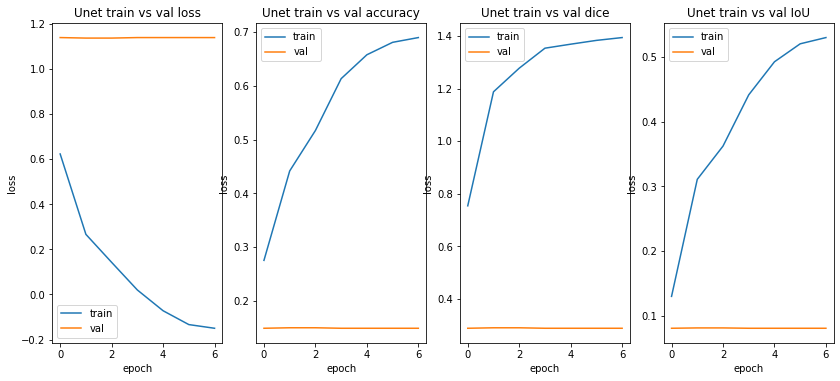

In [ ]:
show_curves(histories)

### MobileNet

In [ ]:
Mobilenet = custom_mobilenet(img_height, img_width)
Mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=total_loss, 
    metrics=[
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])
comp, histories = evaluate_model({"Mobilenet": Mobilenet}, pd.DataFrame(), train_gen, val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
Epoch 1/15
5/5 [==============================] - 40s 6s/step - loss: 0.7096 - iou_score: 0.1002 - f1-score: 0.3169 - accuracy: 0.4266 - val_loss: 1.3165 - val_iou_score: 0.0831 - val_f1-score: 0.1038 - val_accuracy: 0.1648

Epoch 00001: val_loss improved from inf to 1.31652, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
5/5 [==============================] - 29s 5s/step - loss: 0.5370 - iou_score: 0.1811 - f1-score: 0.5491 - accuracy: 0.5789 - val_loss: 1.2996 - val_iou_score: 0.0846 - val_f1-score: 0.1207 - val_accuracy: 0.1648

Epoch 00002: val_loss improved from 1.31652 to 1.29958, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
5/5 [==============================] - 29s 6s/step - loss: 0.4075 - iou_score: 0.2392 - f1-score: 0.6761 - accuracy: 0.6332 - val_loss: 1.3285 - val_iou_score: 0.0811 - val_f1-score: 0.0999 - val_accuracy: 0.1488

Epoch 00003: val_loss did not improve from 1.29958
Epoch 4/15
5/5 [==============================] - 30s 5s/step - loss: 0.3407 - iou_score: 0.2591 - f1-score: 0.7228 - accuracy: 0.6504 - val_loss: 1.3285 - val_iou_score: 0.0811 - val_f1-score: 0.0999 - val_accuracy: 0.1488

Epoch 00004: val_loss did not improve from 1.29958
Epoch 5/15
5/5 [==============================] - 31s 6s/step - loss: 0.2782 - iou_score: 0.2816 - f1-score: 0.7764 - accuracy: 0.6591 - val_loss: 1.3285 - val_iou_score: 0.0811 - val_f1-score: 0.0999 - val_accuracy: 0.1488

Epoch 00005: val_loss did not improve from 1.29958

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 6/15
5/5 [==============================] - 30s 6s/step - loss: 0.2323 - iou_score: 0

In [ ]:
comp

Mobilenet
train time  315.247615
Accuracy      0.164848
IoU           0.084576
Dice          0.120671

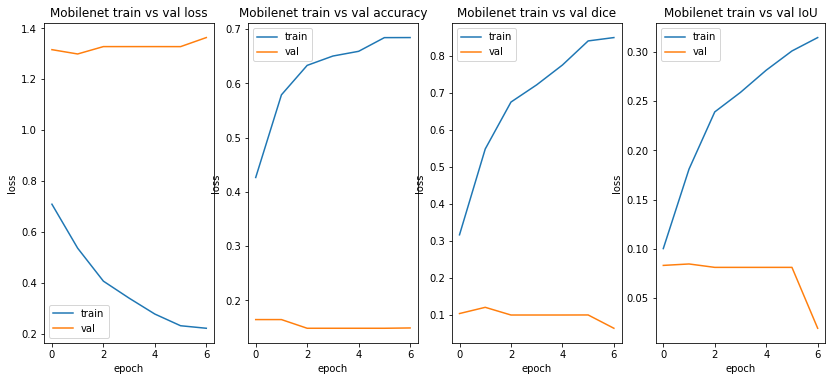

In [ ]:
show_curves(histories)

## Training with augmented datas

In [ ]:
aug_train_gen = DataGenerator(train_img[0:160], train_label[0:160], BATCH_SIZE, data_aug = True, shuffle=True)
aug_test_gen = DataGenerator(test_img[0:64], test_label[0:64], BATCH_SIZE, data_aug = False)
aug_val_gen = DataGenerator(val_img, val_label, BATCH_SIZE, data_aug = False)

TRAIN_STEPS = 160 //BATCH_SIZE
VAL_STEPS = 64 //BATCH_SIZE

# comp, histories = evaluate_model(models, pd.DataFrame(), train_gen, val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)


### Unet

In [ ]:
Unet = UNet(img_height, img_width, 32)
Unet.compile(
    optimizer=tf.keras.optimizers.Adam(0.01), loss=total_loss, 
    metrics=[
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])
comp, histories = evaluate_model({"Augmented Unet": Unet}, pd.DataFrame(), aug_train_gen, aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

Epoch 1/15
14/14 [==============================] - 116s 5s/step - loss: 0.2004 - iou_score: 0.3166 - f1-score: 0.9997 - accuracy: 0.4763 - val_loss: 1.1401 - val_iou_score: 0.0805 - val_f1-score: 0.2887 - val_accuracy: 0.1488

Epoch 00001: val_loss improved from inf to 1.14006, saving model to /content/drive/MyDrive/P8/Augmented Unet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Augmented Unet_21_09_2021/assets
Epoch 2/15
14/14 [==============================] - 39s 2s/step - loss: -0.1005 - iou_score: 0.4418 - f1-score: 1.1865 - accuracy: 0.6101 - val_loss: 1.1401 - val_iou_score: 0.0805 - val_f1-score: 0.2887 - val_accuracy: 0.1488

Epoch 00002: val_loss did not improve from 1.14006
Epoch 3/15
14/14 [==============================] - 40s 2s/step - loss: -0.1501 - iou_score: 0.4678 - f1-score: 1.2329 - accuracy: 0.6340 - val_loss: 1.1392 - val_iou_score: 0.0807 - val_f1-score: 0.2893 - val_accuracy: 0.1492

Epoch 00003: val_loss improved from 1.14006 to 1.13

In [ ]:
ddcomp_aug_unet = comp.copy()
ddcomp_aug_unet

Augmented Unet
train time      880.305126
Accuracy          0.545621
IoU               0.375150
Dice              1.059101

In [ ]:
comp_aug_mob

Augmented MobileNet
train time           889.255958
Accuracy               0.382200
IoU                    0.065491
Dice                   0.293682

With more datas, the overfitting decreases clearly

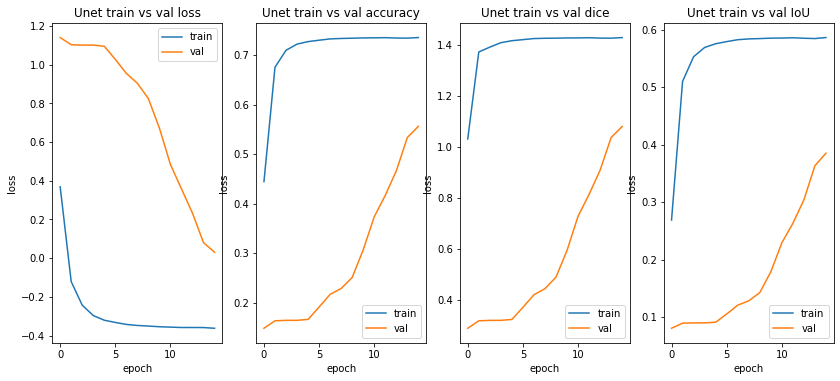

In [ ]:
show_curves(histories)

### MobileNet


In [ ]:
Mobilenet = custom_mobilenet(img_height, img_width)
Mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), loss=total_loss, 
    metrics=[
              sm.metrics.IOUScore(threshold=0.5, smooth=0.5),
              sm.metrics.FScore(threshold=0.5,  smooth=0.5),
              'accuracy'   ])
comp, histories = evaluate_model({"Augmented Mobilenet": Mobilenet}, pd.DataFrame(), aug_train_gen, aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
Epoch 1/15
10/10 [==============================] - 49s 4s/step - loss: 0.6205 - iou_score: 0.1294 - f1-score: 0.4739 - accuracy: 0.4781 - val_loss: 1.1465 - val_iou_score: 0.0023 - val_f1-score: 0.0768 - val_accuracy: 0.0085

Epoch 00001: val_loss improved from inf to 1.14654, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
10/10 [==============================] - 41s 4s/step - loss: 0.4022 - iou_score: 0.2481 - f1-score: 0.7250 - accuracy: 0.6122 - val_loss: 0.9504 - val_iou_score: 0.0141 - val_f1-score: 0.0622 - val_accuracy: 0.0693

Epoch 00002: val_loss improved from 1.14654 to 0.95040, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
10/10 [==============================] - 42s 4s/step - loss: 0.2757 - iou_score: 0.2989 - f1-score: 0.8256 - accuracy: 0.6651 - val_loss: 0.9454 - val_iou_score: 0.0101 - val_f1-score: 0.0573 - val_accuracy: 0.0434

Epoch 00003: val_loss improved from 0.95040 to 0.94538, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
10/10 [==============================] - 41s 4s/step - loss: 0.1986 - iou_score: 0.3293 - f1-score: 0.8814 - accuracy: 0.7126 - val_loss: 0.9432 - val_iou_score: 0.0150 - val_f1-score: 0.0710 - val_accuracy: 0.0709

Epoch 00004: val_loss improved from 0.94538 to 0.94324, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
10/10 [==============================] - 41s 4s/step - loss: 0.1322 - iou_score: 0.3436 - f1-score: 0.9483 - accuracy: 0.7284 - val_loss: 0.8616 - val_iou_score: 0.0224 - val_f1-score: 0.1815 - val_accuracy: 0.1034

Epoch 00005: val_loss improved from 0.94324 to 0.86164, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
10/10 [==============================] - 41s 4s/step - loss: 0.0567 - iou_score: 0.3635 - f1-score: 1.0154 - accuracy: 0.7396 - val_loss: 0.8505 - val_iou_score: 0.0191 - val_f1-score: 0.1463 - val_accuracy: 0.1190

Epoch 00006: val_loss improved from 0.86164 to 0.85054, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
10/10 [==============================] - 41s 4s/step - loss: 0.0093 - iou_score: 0.3647 - f1-score: 1.0629 - accuracy: 0.7399 - val_loss: 0.7832 - val_iou_score: 0.0354 - val_f1-score: 0.2915 - val_accuracy: 0.3378

Epoch 00007: val_loss improved from 0.85054 to 0.78325, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
10/10 [==============================] - 41s 4s/step - loss: -0.0164 - iou_score: 0.3638 - f1-score: 1.0926 - accuracy: 0.7288 - val_loss: 0.8190 - val_iou_score: 0.0283 - val_f1-score: 0.2464 - val_accuracy: 0.1604

Epoch 00008: val_loss did not improve from 0.78325
Epoch 9/15
10/10 [==============================] - 42s 4s/step - loss: -0.0461 - iou_score: 0.3526 - f1-score: 1.1269 - accuracy: 0.7085 - val_loss: 0.7906 - val_iou_score: 0.0655 - val_f1-score: 0.2937 - val_accuracy: 0.3620

Epoch 00009: val_loss did not improve from 0.78325
Epoch 10/15
10/10 [==============================] - 42s 4s/step - loss: -0.0533 - iou_score: 0.3557 - f1-score: 1.1276 - accuracy: 0.6969 - val_loss: 0.7632 - val_iou_score: 0.0585 - val_f1-score: 0.2660 - val_accuracy: 0.3695

Epoch 00010: val_loss improved from 0.78325 to 0.76323, saving model to /content/drive/MyDrive/P8/Mobilenet_21_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Mobilenet_21_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
10/10 [==============================] - 41s 4s/step - loss: -0.0640 - iou_score: 0.3414 - f1-score: 1.1403 - accuracy: 0.6738 - val_loss: 0.7967 - val_iou_score: 0.0580 - val_f1-score: 0.2582 - val_accuracy: 0.3822

Epoch 00011: val_loss did not improve from 0.76323
Epoch 12/15
10/10 [==============================] - 42s 4s/step - loss: -0.0767 - iou_score: 0.3465 - f1-score: 1.1512 - accuracy: 0.6636 - val_loss: 0.8179 - val_iou_score: 0.0558 - val_f1-score: 0.2210 - val_accuracy: 0.3615

Epoch 00012: val_loss did not improve from 0.76323
Epoch 13/15
10/10 [==============================] - 42s 4s/step - loss: -0.1309 - iou_score: 0.3481 - f1-score: 1.2069 - accuracy: 0.6496 - val_loss: 0.8394 - val_iou_score: 0.0496 - val_f1-score: 0.2526 - val_accuracy: 0.3091

Epoch 00013: val_loss did not improve from 0.76323

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 14/15
10/10 [==============================] - 42s 4s/step - loss: -0.17

In [ ]:
comp_aug_mob = comp.copy()
comp

Augmented MobileNet
train time           889.255958
Accuracy               0.382200
IoU                    0.065491
Dice                   0.293682

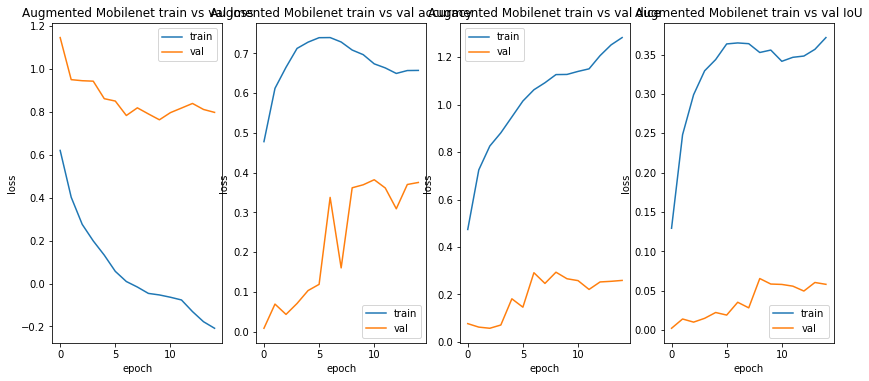

In [ ]:
show_curves(histories)

With augmented datas, Unet Model performs better then mobilenet. IoU is was higher,let 's keep it and use pretrained model.
I'l use `inceptonv3`as a backbone , it's one of the most used and one of the most performant durint each ImageNet competition

# Compare Trained models

Training pretrained model

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
n_classes = 8
activation="softmax"
LR = 0.001
optim = tf.keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]
histories = []


aug_train_gen = DataGenerator(train_img[0:160], train_label[0:160], BATCH_SIZE, data_aug = True, shuffle=True, backbone="inceptionv3")
aug_test_gen = DataGenerator(test_img[0:64], test_label[0:64], BATCH_SIZE, data_aug = False, shuffle=False, backbone="inceptionv3")
aug_val_gen = DataGenerator(val_img, val_label, BATCH_SIZE, data_aug = False, backbone="inceptionv3")

TRAIN_STEPS = 320 //BATCH_SIZE+1
VAL_STEPS = 64 //BATCH_SIZE+1

m_unet = sm.Unet('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
m_unet.compile(optim, total_loss, metrics=metrics)

m_linknet = sm.Linknet('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
m_linknet.compile(optim, total_loss, metrics=metrics)

m_fpn = sm.FPN('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
m_fpn.compile(optim, total_loss, metrics=metrics)

models = {
    "Inception Augm Unet" : m_unet,
    "Inception Augm Linknet": m_linknet,
    "Inception Augm FPN": m_fpn,

    }

comp, histories = evaluate_model(models, pd.DataFrame(), aug_train_gen, aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

Epoch 1/15
11/11 [==============================] - 170s 10s/step - loss: 0.9483 - iou_score: 0.3973 - f1-score: 0.4152 - accuracy: 0.6238 - val_loss: 1.1029 - val_iou_score: 0.3755 - val_f1-score: 0.3760 - val_accuracy: 0.0331

Epoch 00001: val_loss improved from inf to 1.10287, saving model to /content/drive/MyDrive/P8/Inception Augm Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Unet_22_09_2021/assets
Epoch 2/15
11/11 [==============================] - 55s 5s/step - loss: 0.8994 - iou_score: 0.7870 - f1-score: 0.8091 - accuracy: 0.8432 - val_loss: 0.9245 - val_iou_score: 0.4580 - val_f1-score: 0.4770 - val_accuracy: 0.8715

Epoch 00002: val_loss improved from 1.10287 to 0.92450, saving model to /content/drive/MyDrive/P8/Inception Augm Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Unet_22_09_2021/assets
Epoch 3/15
11/11 [==============================] - 75s 7s/step - loss: 0.8769 - iou_score: 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
11/11 [==============================] - 60s 5s/step - loss: 1.0059 - iou_score: 9.3347e-04 - f1-score: 0.0019 - accuracy: 0.1100 - val_loss: 1.0089 - val_iou_score: 0.0740 - val_f1-score: 0.0936 - val_accuracy: 0.2765

Epoch 00002: val_loss improved from 1.13359 to 1.00888, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
11/11 [==============================] - 61s 5s/step - loss: 0.9864 - iou_score: 0.0143 - f1-score: 0.0172 - accuracy: 0.2557 - val_loss: 0.9472 - val_iou_score: 0.1824 - val_f1-score: 0.2041 - val_accuracy: 0.5859

Epoch 00003: val_loss improved from 1.00888 to 0.94725, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
11/11 [==============================] - 76s 7s/step - loss: 0.9680 - iou_score: 0.0407 - f1-score: 0.0467 - accuracy: 0.4450 - val_loss: 0.9411 - val_iou_score: 0.2052 - val_f1-score: 0.2256 - val_accuracy: 0.6086

Epoch 00004: val_loss improved from 0.94725 to 0.94106, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
11/11 [==============================] - 77s 7s/step - loss: 0.9502 - iou_score: 0.2540 - f1-score: 0.2659 - accuracy: 0.6795 - val_loss: 0.9328 - val_iou_score: 0.2520 - val_f1-score: 0.2731 - val_accuracy: 0.6862

Epoch 00005: val_loss improved from 0.94106 to 0.93279, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
11/11 [==============================] - 77s 7s/step - loss: 0.9340 - iou_score: 0.3827 - f1-score: 0.4015 - accuracy: 0.8240 - val_loss: 0.9271 - val_iou_score: 0.3012 - val_f1-score: 0.3227 - val_accuracy: 0.7677

Epoch 00006: val_loss improved from 0.93279 to 0.92709, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
11/11 [==============================] - 59s 5s/step - loss: 0.9188 - iou_score: 0.4220 - f1-score: 0.4439 - accuracy: 0.8564 - val_loss: 0.9240 - val_iou_score: 0.3431 - val_f1-score: 0.3645 - val_accuracy: 0.8468

Epoch 00007: val_loss improved from 0.92709 to 0.92401, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
11/11 [==============================] - 60s 5s/step - loss: 0.9072 - iou_score: 0.4754 - f1-score: 0.4949 - accuracy: 0.8682 - val_loss: 0.9236 - val_iou_score: 0.4627 - val_f1-score: 0.4841 - val_accuracy: 0.8602

Epoch 00008: val_loss improved from 0.92401 to 0.92363, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
11/11 [==============================] - 77s 7s/step - loss: 0.8996 - iou_score: 0.6072 - f1-score: 0.6220 - accuracy: 0.8705 - val_loss: 0.9232 - val_iou_score: 0.7095 - val_f1-score: 0.7309 - val_accuracy: 0.8622

Epoch 00009: val_loss improved from 0.92363 to 0.92324, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
11/11 [==============================] - 62s 5s/step - loss: 0.8942 - iou_score: 0.7293 - f1-score: 0.7423 - accuracy: 0.8713 - val_loss: 0.9208 - val_iou_score: 0.7958 - val_f1-score: 0.8178 - val_accuracy: 0.8628

Epoch 00010: val_loss improved from 0.92324 to 0.92082, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
11/11 [==============================] - 61s 5s/step - loss: 0.8904 - iou_score: 0.8013 - f1-score: 0.8139 - accuracy: 0.8714 - val_loss: 0.9183 - val_iou_score: 0.7977 - val_f1-score: 0.8200 - val_accuracy: 0.8621

Epoch 00011: val_loss improved from 0.92082 to 0.91828, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
11/11 [==============================] - 62s 5s/step - loss: 0.8874 - iou_score: 0.8608 - f1-score: 0.8740 - accuracy: 0.8712 - val_loss: 0.9152 - val_iou_score: 0.8010 - val_f1-score: 0.8236 - val_accuracy: 0.8606

Epoch 00012: val_loss improved from 0.91828 to 0.91521, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
11/11 [==============================] - 61s 5s/step - loss: 0.8849 - iou_score: 0.8624 - f1-score: 0.8762 - accuracy: 0.8699 - val_loss: 0.9118 - val_iou_score: 0.8054 - val_f1-score: 0.8282 - val_accuracy: 0.8589

Epoch 00013: val_loss improved from 0.91521 to 0.91184, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/15
11/11 [==============================] - 62s 5s/step - loss: 0.8827 - iou_score: 0.8637 - f1-score: 0.8783 - accuracy: 0.8684 - val_loss: 0.9084 - val_iou_score: 0.8114 - val_f1-score: 0.8343 - val_accuracy: 0.8572

Epoch 00014: val_loss improved from 0.91184 to 0.90838, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/15
11/11 [==============================] - 77s 7s/step - loss: 0.8799 - iou_score: 0.8662 - f1-score: 0.8828 - accuracy: 0.8680 - val_loss: 0.9054 - val_iou_score: 0.8182 - val_f1-score: 0.8409 - val_accuracy: 0.8572

Epoch 00015: val_loss improved from 0.90838 to 0.90544, saving model to /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm Linknet_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/15
11/11 [==============================] - 96s 7s/step - loss: 0.9378 - iou_score: 0.4525 - f1-score: 0.4691 - accuracy: 0.6846 - val_loss: 1.3143 - val_iou_score: 0.5186 - val_f1-score: 0.5336 - val_accuracy: 0.1428

Epoch 00001: val_loss improved from inf to 1.31428, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
11/11 [==============================] - 80s 7s/step - loss: 0.8815 - iou_score: 0.8512 - f1-score: 0.8646 - accuracy: 0.8584 - val_loss: 1.0730 - val_iou_score: 0.5386 - val_f1-score: 0.5665 - val_accuracy: 0.2692

Epoch 00002: val_loss improved from 1.31428 to 1.07296, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
11/11 [==============================] - 66s 5s/step - loss: 0.8768 - iou_score: 0.8653 - f1-score: 0.8815 - accuracy: 0.8540 - val_loss: 1.0865 - val_iou_score: 0.7884 - val_f1-score: 0.8163 - val_accuracy: 0.2684

Epoch 00003: val_loss did not improve from 1.07296
Epoch 4/15
11/11 [==============================] - 65s 5s/step - loss: 0.8702 - iou_score: 0.8675 - f1-score: 0.8882 - accuracy: 0.8343 - val_loss: 1.0860 - val_iou_score: 0.8007 - val_f1-score: 0.8328 - val_accuracy: 0.3727

Epoch 00004: val_loss did not improve from 1.07296
Epoch 5/15
11/11 [==============================] - 64s 5s/step - loss: 0.8612 - iou_score: 0.8703 - f1-score: 0.8973 - accuracy: 0.7974 - val_loss: 0.9768 - val_iou_score: 0.8366 - val_f1-score: 0.8682 - val_accuracy: 0.6470

Epoch 00005: val_loss improved from 1.07296 to 0.97676, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_202

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/15
11/11 [==============================] - 64s 5s/step - loss: 0.8549 - iou_score: 0.8804 - f1-score: 0.9078 - accuracy: 0.8285 - val_loss: 0.8763 - val_iou_score: 0.8655 - val_f1-score: 0.8873 - val_accuracy: 0.8392

Epoch 00006: val_loss improved from 0.97676 to 0.87634, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
11/11 [==============================] - 64s 5s/step - loss: 0.8478 - iou_score: 0.8974 - f1-score: 0.9240 - accuracy: 0.8876 - val_loss: 0.8666 - val_iou_score: 0.8813 - val_f1-score: 0.9062 - val_accuracy: 0.8607

Epoch 00007: val_loss improved from 0.87634 to 0.86655, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
11/11 [==============================] - 66s 5s/step - loss: 0.8377 - iou_score: 0.9086 - f1-score: 0.9358 - accuracy: 0.8994 - val_loss: 0.8655 - val_iou_score: 0.8844 - val_f1-score: 0.9105 - val_accuracy: 0.8586

Epoch 00008: val_loss improved from 0.86655 to 0.86546, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
11/11 [==============================] - 65s 5s/step - loss: 0.8331 - iou_score: 0.9104 - f1-score: 0.9382 - accuracy: 0.8952 - val_loss: 0.8648 - val_iou_score: 0.8861 - val_f1-score: 0.9132 - val_accuracy: 0.8543

Epoch 00009: val_loss improved from 0.86546 to 0.86477, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
11/11 [==============================] - 65s 5s/step - loss: 0.8275 - iou_score: 0.9148 - f1-score: 0.9424 - accuracy: 0.8998 - val_loss: 0.8598 - val_iou_score: 0.8870 - val_f1-score: 0.9140 - val_accuracy: 0.8589

Epoch 00010: val_loss improved from 0.86477 to 0.85980, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
11/11 [==============================] - 65s 5s/step - loss: 0.8248 - iou_score: 0.9072 - f1-score: 0.9341 - accuracy: 0.9092 - val_loss: 0.8588 - val_iou_score: 0.8863 - val_f1-score: 0.9129 - val_accuracy: 0.8597

Epoch 00011: val_loss improved from 0.85980 to 0.85879, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/15
11/11 [==============================] - 65s 5s/step - loss: 0.8213 - iou_score: 0.9216 - f1-score: 0.9482 - accuracy: 0.9125 - val_loss: 0.8566 - val_iou_score: 0.8877 - val_f1-score: 0.9148 - val_accuracy: 0.8596

Epoch 00012: val_loss improved from 0.85879 to 0.85659, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
11/11 [==============================] - 80s 7s/step - loss: 0.8175 - iou_score: 0.9247 - f1-score: 0.9510 - accuracy: 0.9165 - val_loss: 0.8499 - val_iou_score: 0.8931 - val_f1-score: 0.9204 - val_accuracy: 0.8737

Epoch 00013: val_loss improved from 0.85659 to 0.84991, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/15
11/11 [==============================] - 66s 5s/step - loss: 0.8150 - iou_score: 0.9270 - f1-score: 0.9529 - accuracy: 0.9189 - val_loss: 0.8484 - val_iou_score: 0.8944 - val_f1-score: 0.9216 - val_accuracy: 0.8774

Epoch 00014: val_loss improved from 0.84991 to 0.84837, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/15
11/11 [==============================] - 65s 5s/step - loss: 0.8124 - iou_score: 0.9293 - f1-score: 0.9548 - accuracy: 0.9220 - val_loss: 0.8475 - val_iou_score: 0.8939 - val_f1-score: 0.9207 - val_accuracy: 0.8795

Epoch 00015: val_loss improved from 0.84837 to 0.84746, saving model to /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Inception Augm FPN_22_09_2021/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
comp

Inception Augm Unet  Inception Augm Linknet  Inception Augm FPN
train time           770.480673             1667.707800         1616.752173
Accuracy               0.874482                0.862805            0.879549
IoU                    0.859303                0.818212            0.894423
Dice                   0.874554                0.840894            0.921628

FPN is a bit more performant, but the training time difference is pretty big. I'll go with Unet and try to hypertune it to improve its performances.

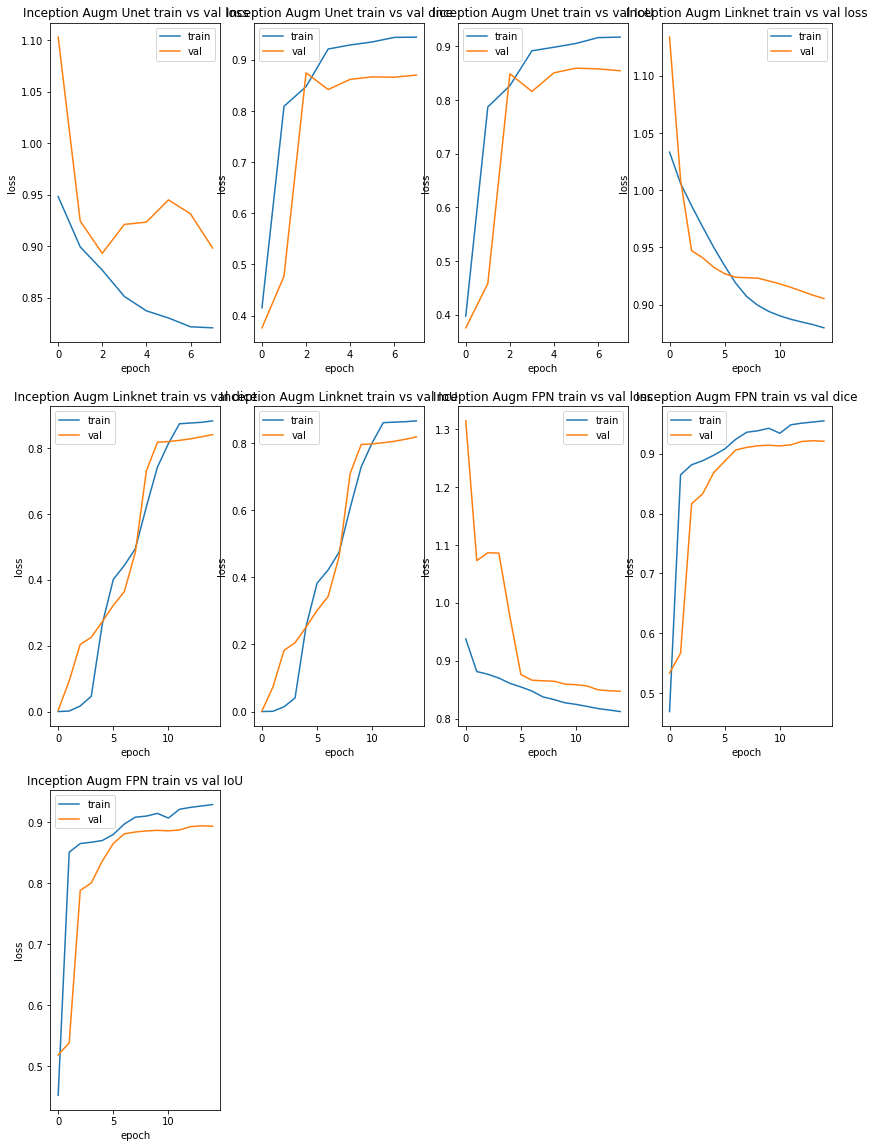

In [ ]:
show_curves_TF(histories)

# Compare with weights


I'll create regular weights, based on class prominence, and ethical weights, based on what is a key objective for an autonomous vehicle: people, vehicle..

## Regular weights

32 classes, 8 groups, the more classes in, the more weights

In [ ]:
regular_cw = [0.2, 0.1, 0.18, 0.11, 0.06, 0.03, 0.06, 0.26]
# ethical_cw = [0.2, 0.1, 0.1, 0.16, 0.12, 0.01, 0.18, 0.13]
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)

dice_loss = sm.losses.DiceLoss(class_weights=regular_cw) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

m_unet_rw = sm.Unet('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
m_unet_rw.compile(optim, total_loss, metrics=metrics)

comp, histories = evaluate_model({'Reg weights Unet': m_unet_rw}, pd.DataFrame(), aug_train_gen, aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

Epoch 1/15
11/11 [==============================] - 76s 6s/step - loss: 1.0375 - iou_score: 3.5225e-04 - f1-score: 7.0271e-04 - accuracy: 0.4313 - val_loss: 1.2936 - val_iou_score: 0.0058 - val_f1-score: 0.0111 - val_accuracy: 0.0161

Epoch 00001: val_loss improved from inf to 1.29356, saving model to /content/drive/MyDrive/P8/Reg weights Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Reg weights Unet_22_09_2021/assets
Epoch 2/15
11/11 [==============================] - 79s 7s/step - loss: 1.0071 - iou_score: 0.2798 - f1-score: 0.2850 - accuracy: 0.8454 - val_loss: 1.1627 - val_iou_score: 0.1408 - val_f1-score: 0.1534 - val_accuracy: 0.1144

Epoch 00002: val_loss improved from 1.29356 to 1.16267, saving model to /content/drive/MyDrive/P8/Reg weights Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Reg weights Unet_22_09_2021/assets
Epoch 3/15
11/11 [==============================] - 64s 5s/step - loss: 0.9924 - iou_score: 0.5282

In [ ]:
comp

Reg weights Unet
train time       1730.652413
Accuracy            0.874990
IoU                 0.859296
Dice                0.866627

With "regular weights", training time is way longer, and performances are not improving.

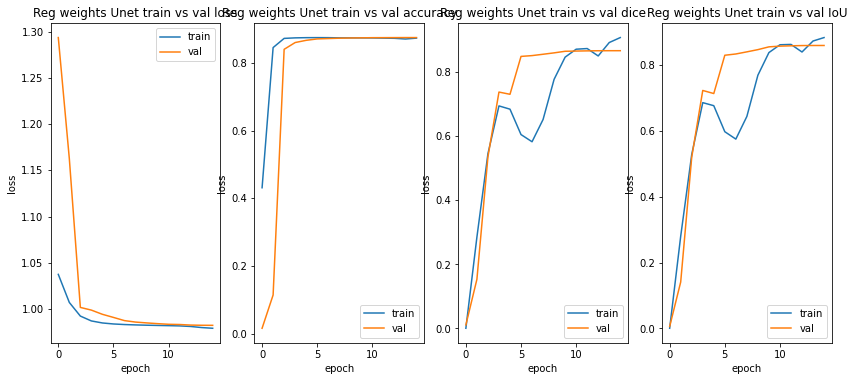

In [ ]:
show_curves(histories)

## Ethical weights

Here we try to give more weights to important items for an autonomous vehicle, e.g. multiplied human weight by x5, reduced void/sky/flat weights, improved a bit objets weights...almost no weight to void, flat and sky
```
cats = {'void': [0, 1, 2, 3, 4, 5, 6], # ALMOST NO WEIGHT
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25], ** # THE MOST WEIGHT**
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}  ** # MORE WEIGHT THAN OTHERS**
 ```


In [ ]:
# regular_cw = [0.2, 0.1, 0.18, 0.11, 0.06, 0.03, 0.06, 0.26]
ethical_cw = [0.01, 0.01, 0.05, 0.05, 0.07, 0.01, 0.5, 0.3] # 


dice_loss = sm.losses.DiceLoss(class_weights=ethical_cw) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

m_unet_ethw = sm.Unet('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
m_unet_ethw.compile(optim, total_loss, metrics=metrics)

comp, histories = evaluate_model({'Eth weights Unet': m_unet_ethw}, comp, aug_train_gen, aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 15)

Epoch 1/15
11/11 [==============================] - 76s 6s/step - loss: 1.0410 - iou_score: 0.0684 - f1-score: 0.0685 - accuracy: 0.4256 - val_loss: 1.4200 - val_iou_score: 0.1255 - val_f1-score: 0.1260 - val_accuracy: 0.0036

Epoch 00001: val_loss improved from inf to 1.41996, saving model to /content/drive/MyDrive/P8/Eth weights Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Eth weights Unet_22_09_2021/assets
Epoch 2/15
11/11 [==============================] - 64s 5s/step - loss: 1.0173 - iou_score: 0.6290 - f1-score: 0.6324 - accuracy: 0.8486 - val_loss: 1.0635 - val_iou_score: 0.3007 - val_f1-score: 0.3291 - val_accuracy: 0.4466

Epoch 00002: val_loss improved from 1.41996 to 1.06346, saving model to /content/drive/MyDrive/P8/Eth weights Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Eth weights Unet_22_09_2021/assets
Epoch 3/15
11/11 [==============================] - 66s 5s/step - loss: 1.0082 - iou_score: 0.8308 - f1-sc

In [ ]:
comp

Reg weights Unet  Eth weights Unet  No Weights
train time       1730.652413       1823.052523  770.480673
Accuracy            0.874990          0.867999    0.874482
IoU                 0.859296          0.858113    0.859303
Dice                0.866627          0.869699    0.874554

Weights add time but do not improve performance

# Training on full augmented dataset

Training on full, augmented dataset, with a pretrained inceptionv3 Unet

In [17]:
full_aug_train_gen = DataGenerator(train_img, train_label, BATCH_SIZE, data_aug = True, shuffle=True,backbone='inceptionv3')
full_aug_test_gen = DataGenerator(test_img, test_label, BATCH_SIZE, data_aug = False, backbone='inceptionv3')
full_aug_val_gen = DataGenerator(val_img, val_label, BATCH_SIZE, data_aug = False, backbone='inceptionv3')

In [ ]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
n_classes = 8
activation="softmax"
LR = 0.01
optim = tf.keras.optimizers.Adam(LR)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]


final_model = sm.Unet('inceptionv3', encoder_weights='imagenet', classes=n_classes, activation=activation)
final_model.compile(optim, total_loss, metrics=metrics)

TRAIN_STEPS = len(full_aug_train_gen) //BATCH_SIZE+1
VAL_STEPS = len(full_aug_test_gen) //BATCH_SIZE+1


comp, histories = evaluate_model({'Full train Unet': final_model}, pd.DataFrame(), full_aug_train_gen, full_aug_val_gen, TRAIN_STEPS, VAL_STEPS, BATCH_SIZE, 150)


87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/150
3/3 [==============================] - 135s 38s/step - loss: 0.9633 - iou_score: 0.2317 - f1-score: 0.2395 - accuracy: 0.5255 - val_loss: 0.4463 - val_iou_score: 0.6094 - val_f1-score: 0.6167 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.44631, saving model to /content/drive/MyDrive/P8/Full train Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Full train Unet_22_09_2021/assets
Epoch 2/150
3/3 [==============================] - 68s 14s/step - loss: 0.8895 - iou_score: 0.8555 - f1-score: 0.8644 - accuracy: 0.8748 - val_loss: 0.1963 - val_iou_score: 0.8594 - val_f1-score: 0.8667 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.44631 to 0.19632, saving model to /content/drive/MyDrive/P8/Full train Unet_22_09_2021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/P8/Full train Unet_22_09_2021/assets
Epoch 3/150
3/3 [===========================

In [ ]:
comp

Full train Unet
train time      1388.105141
Accuracy           0.874970
IoU                0.859843
Dice               0.873920

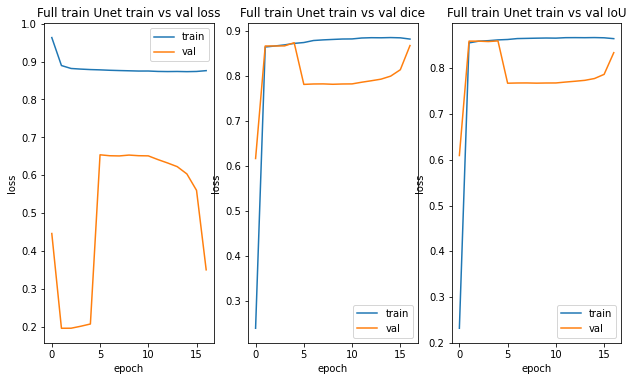

In [ ]:
show_curves_TF(histories)

# Predict some random images


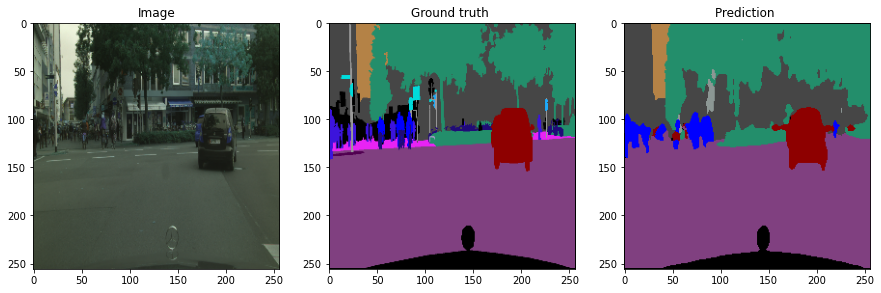

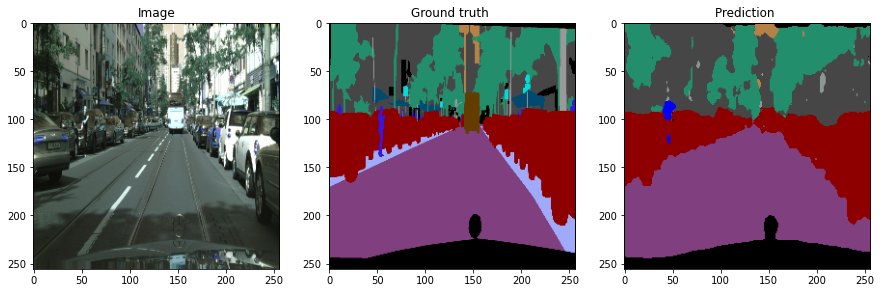

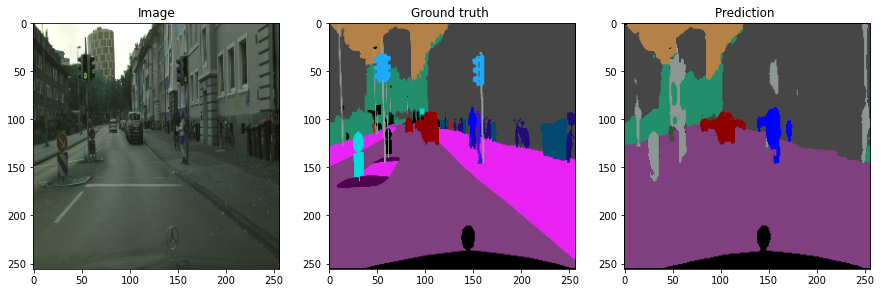

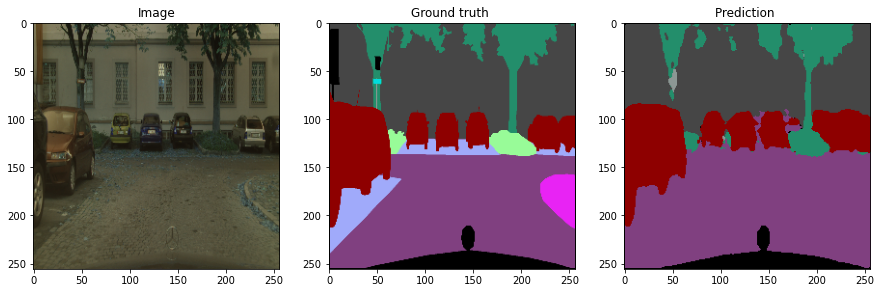

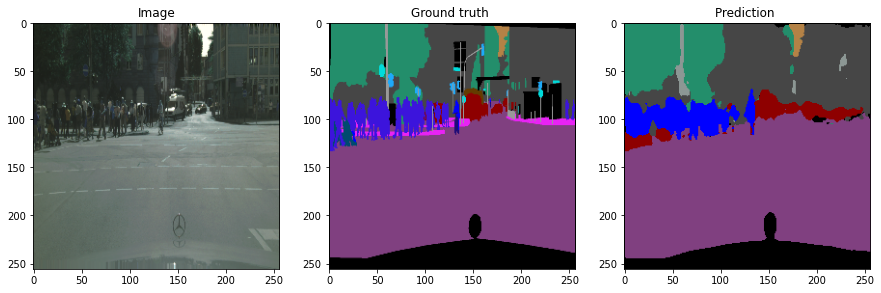

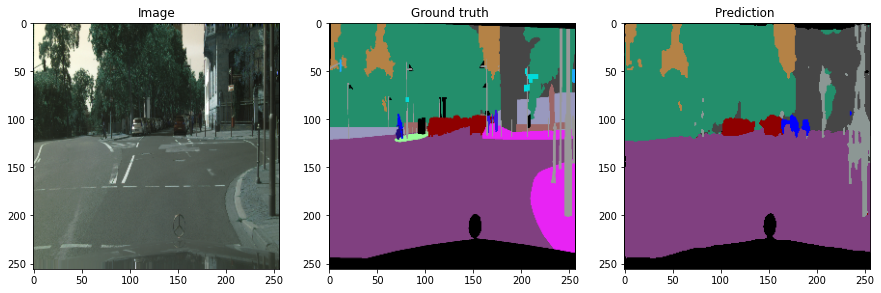

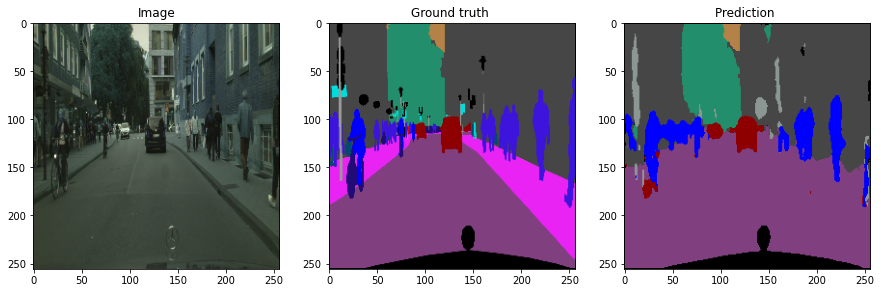

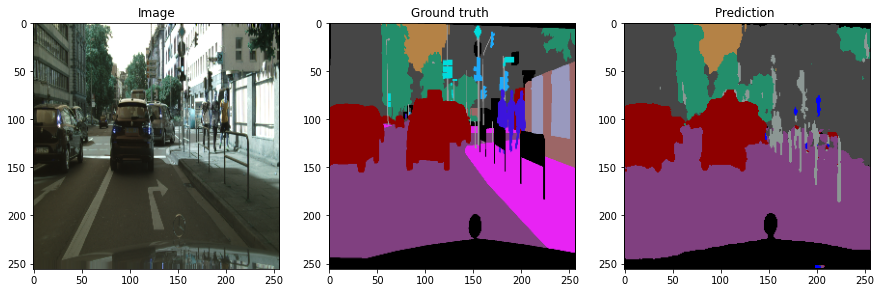

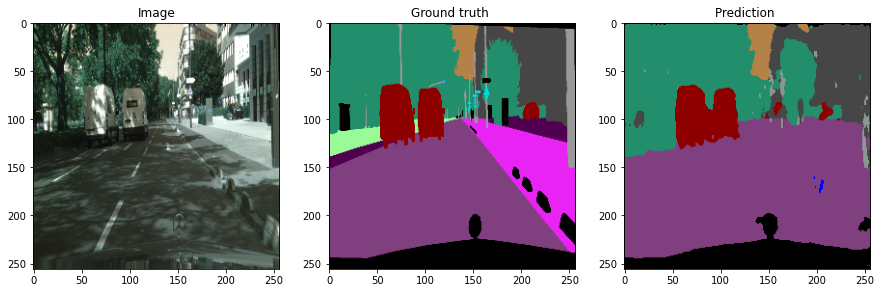

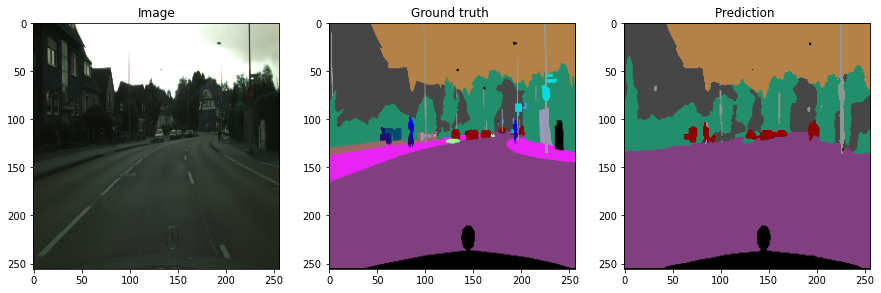

In [40]:
for i in range(0,10):
    j = random.randint(0, len(val_img))
    gt = cv2.imread(val_gt[j], cv2.IMREAD_COLOR)       
    gt = cv2.resize(gt, (img_height, img_width))
    img, pred = get_eval(final_model, j)
    show_img_grid(img, gt, pred)


# Azure deployment

## Libraries

In [ ]:
!pip install azureml-sdk
!pip install azureml
!pip install azureml-core
!pip install azureml-contrib-services
import azureml.core
from azureml.core import Workspace
from azureml.core import Model
from azureml.core.resource_configuration import ResourceConfiguration
from azureml.core.webservice import AciWebservice, AksWebservice, Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

## Workspace load

In [ ]:
Model.get_model_path(model_name = 'segmentation_model', _workspace = ws)

'azureml-models/segmentation_model/24/base_model'

In [ ]:
ws = Workspace.from_config('/content/drive/MyDrive/P8/config.json')
# segmentation_model = Model(ws, 'segmentation_model')
# segmentation_weights = Model(ws, 'segmentation_weights')
# # Model.get_model_path(model_name = 'segmentation_model', version=2)
# segmentation_weights

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code D2NVWE727 to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.


In [ ]:
model = load_model(Model.get_model_path('segmentation_model', _workspace=ws))
print("model loaded", model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
print("model copiled", model)
# weights = load_model(Model.get_model_path('segmentation_weights', _workspace=ws))

## Models registration

In [ ]:
final_model = Model.register(workspace = ws,
                       model_path= '/content/drive/MyDrive/P8/Flask/base',
                       model_name = 'segmentation_model_h5',
                       description = 'Cityscapes images segmentation model')

weights = Model.register(workspace = ws,
                       model_path= '/content/drive/MyDrive/P8/Flask/segmentation.h5',
                       model_name = 'segmentation_weights',
                       description = 'Cityscapes images segmentation model weights')


Registering model segmentation_model_h5


## Config and deployment


In [ ]:
from azureml.core.model import Model
from azureml.core import Workspace, Dataset
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
import joblib
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.webservice import LocalWebservice
import  json

 
ws = Workspace.from_config('/content/drive/MyDrive/P8/config.json')
 
p8env = Environment(workspace=ws, name = 'p8env')
p8env.python.conda_dependencies = CondaDependencies.create(pip_packages=[
    'azureml-defaults',
    'numpy=={}'.format(np.__version__),
    'joblib=={}'.format(joblib.__version__),
    'tensorflow=={}'.format(tf.__version__),
    'opencv-python-headless',
    'scikit-image',
    'mathematics', 
    'scikit-learn',
    'pandas',
    'azure-storage-file-datalake',
    'segmentation_models'
    
])
env_variables={
    "subscription_id": os.environ["AZURE_SUB_ID"],
    "resource_group": "OCR2",
    "workspace_name": "ocrp8", 
    "service_principal_id": os.environ["AZURE_SERV_MAIN_ID"],
    "service_principal_password": os.environ["AZURE_SERV_MAIN_PWD"],
    "tenant_id": os.environ["AZURE_TENANT_ID"],
    "adls_credentials": os.environ["AZURE_ADLS_CREDS"]
}
p8env.environment_variables = env_variables
aci_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2)
 
inference_config = InferenceConfig(entry_script="score.py", source_directory="model/", environment=p8env)
 
logger.info("Inference config setted")
 
logger.info("DEPLOYING")
service = Model.deploy(workspace=ws,
                name='segmentation-model-final',
                models=[model, weights],
                inference_config=inference_config,
                deployment_config=aci_config,
                overwrite=True)
# Wait for the deployment to complete
service.wait_for_deployment(True)

logger.info(service.get_logs())